# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 0: All Imports

Include all imported packages that will be used in this practical application. 

In [2]:

import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')

import multiprocessing

### Problem 1: Understanding the Data



To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data collected in the dataset is related to 17 marketing campaigns ran by the Portugese banking institution between May 2008 to November 2010, corresponding to a total of 79354 contacts. During phone campaigns, a long-term deposit application with favorable interest rates was offered. A  database was maintained containing attributes for each contact, including whether the target variable (success) was achieved. The overall success rate across the entire database was 8%.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [3]:
bank_data = pd.read_csv('./data/bank-additional-full.csv', sep = ';')

In [4]:
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



#### Missing Values:
- Some categorical variables have a category labeled as "unknown", indicating missing values. These include `job`, `marital`, `education`, `default`, `housing`, and `loan`. 

#### Data Types:
- `job`, `marital`, `education`, `default`, `housing`, `loan`, `contact`, `month`, `day_of_week`, and `poutcome` are categorical.
- `age`, `duration`, `campaign`, `pdays`, `previous`, `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, and `nr.employed` are numeric.

#### Additional Consideration:
- `duration` is noted to be very influential on the target variable and should be discarded for predictive modeling purposes due to only being known after the call.
- Data with 'illiterate' value for the `education` feature should be removed since there is insufficent (low percentage of the overall dataset) data for those customers, which make the model perform worse

Missing values can be handled through imputation or using techniques suitable for the model being applied. Categorical variables need encoding and numeric variables may require scaling.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [5]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
bank_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### Business Objective

The goal of this task is to develop a predictive model that effectively explains the success of a contact, specifically whether the client subscribes to the deposit offered during the campaign. By achieving this, the bank can enhance campaign efficiency by identifying characteristics that influence success. This understanding will lead to improved resource management, including optimizing human effort, phone calls, and time allocation. Identifying a high-quality and cost-effective group of potential customers who are likely to subscribe to the deposit will maximize the ROI in marketing efforts.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

_Create a subset of the dataframe containing the relevant bank data features_

In [7]:
bank_data_sub = bank_data[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']]

_Drop rows with missing values and rows that have "unknown" as a value_

In [8]:
# drop rows with missing values
bank_data_sub = bank_data_sub.dropna()

# drop rows where value is unknown
bank_data_sub = bank_data_sub[(bank_data_sub != 'unknown').all(1)]

# drop rowa where value is illiterate
bank_data_sub = bank_data_sub[bank_data_sub.education != 'illiterate']

bank_data_sub.head()

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,no,no,no,no
2,37,services,married,high.school,no,yes,no,no
3,40,admin.,married,basic.6y,no,no,no,no
4,56,services,married,high.school,no,no,yes,no
6,59,admin.,married,professional.course,no,no,no,no


In [9]:
bank_data_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30477 entries, 0 to 41187
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        30477 non-null  int64 
 1   job        30477 non-null  object
 2   marital    30477 non-null  object
 3   education  30477 non-null  object
 4   default    30477 non-null  object
 5   housing    30477 non-null  object
 6   loan       30477 non-null  object
 7   y          30477 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [10]:
# split data into features and target
X = bank_data_sub.drop('y', axis = 1)
y = bank_data_sub['y']

_Instead of encoding categorical variables manually, we can use the ColumnTransformer class from scikit-learn to apply the encoding to the categorical variables and scaling to the numerical variables in one step_

In [11]:
selector = make_column_selector(dtype_include=object)
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), selector),
                                     remainder = StandardScaler())

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 143)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [13]:
dummy = DummyClassifier(strategy = 'stratified')
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

accuracy_score(y_test, dummy_pred)

0.7764107611548556

The baseline performance that our classifier should aim to beat is 77.64%. 

### Problem 8: A Simple Model

**Use Logistic Regression to build a basic model on your data.**

In [14]:
# logistic regression

lgr_pipe = Pipeline([('transformer', transformer),
                    ('lgr', LogisticRegression())])

start_time = time.time()

lgr_pipe.fit(X_train, y_train)
lgr_fit_time = time.time() - start_time

lgr_train_score = lgr_pipe.score(X_train, y_train)

lgr_pred = lgr_pipe.predict(X_test)
lgr_test_score = accuracy_score(y_test, lgr_pred)

print(lgr_pipe)
print("Fit time: ", lgr_fit_time)
print("Train score: ", lgr_train_score)
print("Test score: ", lgr_test_score)


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee31899270>)])),
                ('lgr', LogisticRegression())])
Fit time:  0.22238397598266602
Train score:  0.8745334481768591
Test score:  0.869258530183727


### Problem 9: Score the Model

What is the accuracy of your model?

The accuracy of the simple logistic regression model is 86.93%.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

**Use KNN to build a basic model on your data.**  

In [15]:
# KNN

knn_pipe = Pipeline([('transformer', transformer),
                    ('knn', KNeighborsClassifier())])

start_time = time.time()

knn_pipe.fit(X_train, y_train)
knn_fit_time = time.time() - start_time

knn_train_score = knn_pipe.score(X_train, y_train)

knn_pred = knn_pipe.predict(X_test)
knn_test_score = accuracy_score(y_test, knn_pred)

print(knn_pipe)
print("Fit time: ", knn_fit_time)
print("Train score: ", knn_train_score)
print("Test score: ", knn_test_score)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee31899270>)])),
                ('knn', KNeighborsClassifier())])
Fit time:  0.06344127655029297
Train score:  0.878840080390468
Test score:  0.86499343832021


**Use Decision Tree to build a basic model on your data.**

In [16]:
# Decision Tree

dt_pipe = Pipeline([('transformer', transformer),
                    ('dt', DecisionTreeClassifier())])

start_time = time.time()

dt_pipe.fit(X_train, y_train)
dt_fit_time = time.time() - start_time

dt_train_score = dt_pipe.score(X_train, y_train)

dt_pred = dt_pipe.predict(X_test)
dt_test_score = accuracy_score(y_test, dt_pred)

print(dt_pipe)
print("Fit time: ", dt_fit_time)
print("Train score: ", dt_train_score)
print("Test score: ", dt_test_score)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee31899270>)])),
                ('dt', DecisionTreeClassifier())])
Fit time:  0.21805286407470703
Train score:  0.9003732414585128
Test score:  0.8551509186351706


**Use SVM to build a basic model on your data.**

In [17]:
# SVM

svm_pipe = Pipeline([('transformer', transformer),
                    ('svm', SVC())])

start_time = time.time()

svm_pipe.fit(X_train, y_train)
svm_fit_time = time.time() - start_time

svm_train_score = svm_pipe.score(X_train, y_train)

svm_pred = svm_pipe.predict(X_test)
svm_test_score = accuracy_score(y_test, svm_pred)

print(svm_pipe)
print("Fit time: ", svm_fit_time)
print("Train score: ", svm_train_score)
print("Test score: ", svm_test_score)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fee31899270>)])),
                ('svm', SVC())])
Fit time:  14.126024007797241
Train score:  0.8747385259013166
Test score:  0.8694225721784777


#### Findings

In [18]:
findings_dict = {'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC'],
           'train score': [lgr_train_score, knn_train_score, dt_train_score, svm_train_score],
           'test score': [lgr_test_score, knn_test_score, dt_test_score, svm_test_score],
           'average fit time': [lgr_fit_time, knn_fit_time, dt_fit_time, svm_fit_time]}
findings_df = pd.DataFrame(findings_dict)
findings_df

,model,train score,test score,average fit time
0,Logistic Regression,0.874533,0.869259,0.222384
1,KNN,0.878840,0.864993,0.063441
2,Decision Tree,0.900373,0.855151,0.218053
3,SVC,0.874739,0.869423,14.126024


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  
- Hyperparameter tuning and grid search.
- Adjust the performance metric

#### Clean the data with all the features

In [19]:
# drop rows with missing values
bank_clean_data = bank_data.dropna()

# drop rows where value is unknown
bank_clean_data = bank_clean_data[(bank_clean_data != 'unknown').all(1)]

#drop rows where education is illiterate
bank_clean_data = bank_clean_data[(bank_clean_data != 'illiterate').all(1)]

bank_clean_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [20]:
bank_clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30477 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30477 non-null  int64  
 1   job             30477 non-null  object 
 2   marital         30477 non-null  object 
 3   education       30477 non-null  object 
 4   default         30477 non-null  object 
 5   housing         30477 non-null  object 
 6   loan            30477 non-null  object 
 7   contact         30477 non-null  object 
 8   month           30477 non-null  object 
 9   day_of_week     30477 non-null  object 
 10  duration        30477 non-null  int64  
 11  campaign        30477 non-null  int64  
 12  pdays           30477 non-null  int64  
 13  previous        30477 non-null  int64  
 14  poutcome        30477 non-null  object 
 15  emp.var.rate    30477 non-null  float64
 16  cons.price.idx  30477 non-null  float64
 17  cons.conf.idx   30477 non-null 

#### Exploratory Data Analysis

Perform EDA to see which features should be included

##### Create a bar plot for each categorical feature based on the response

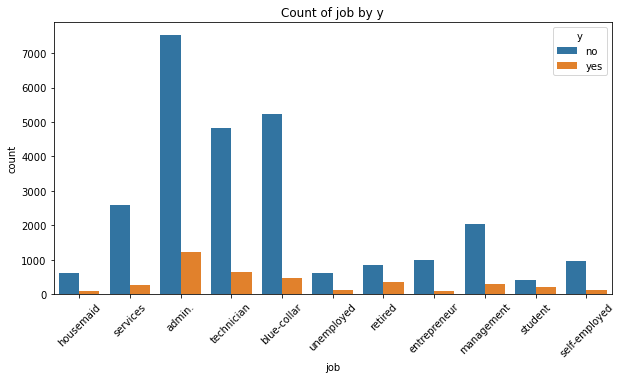

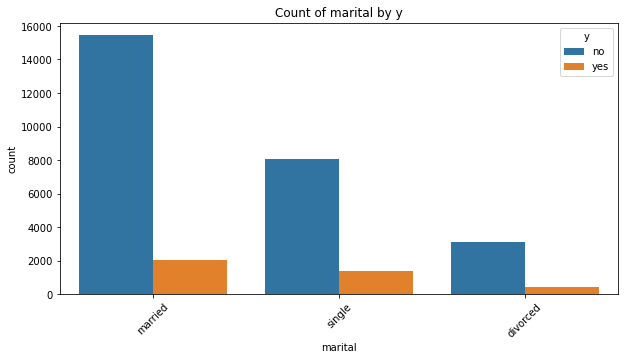

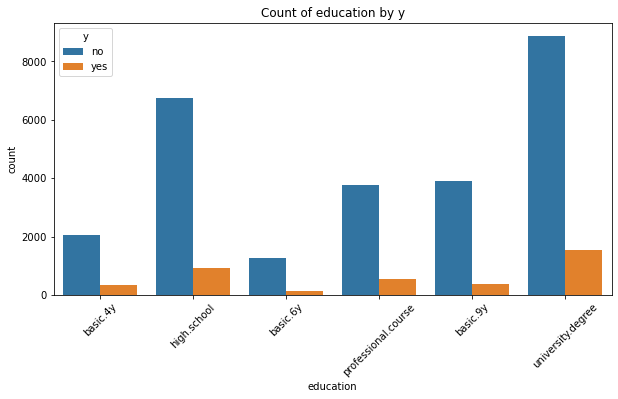

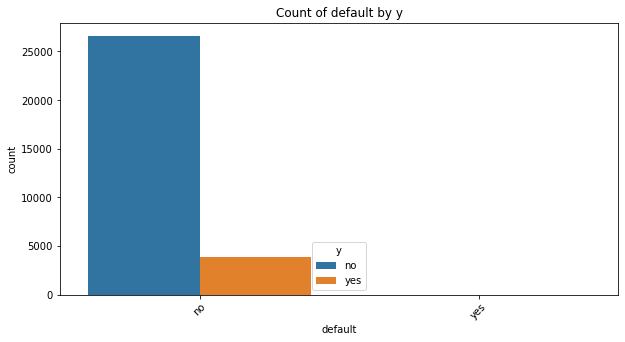

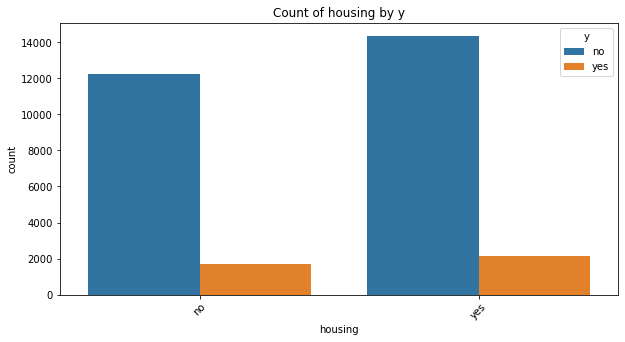

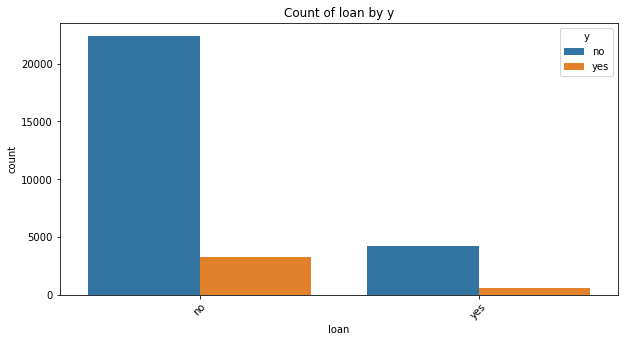

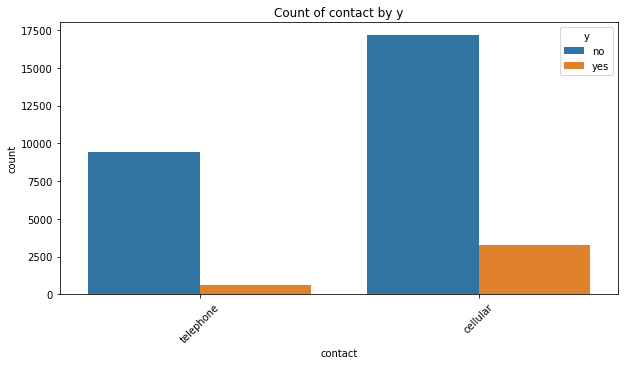

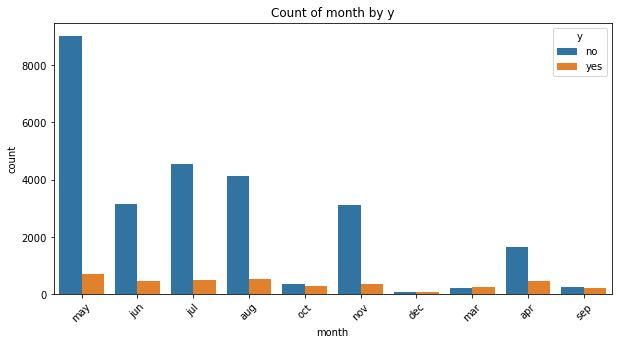

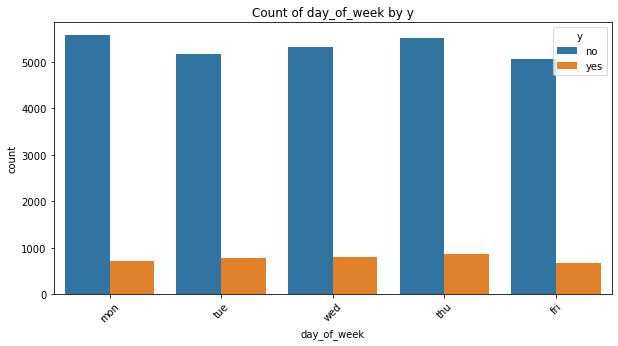

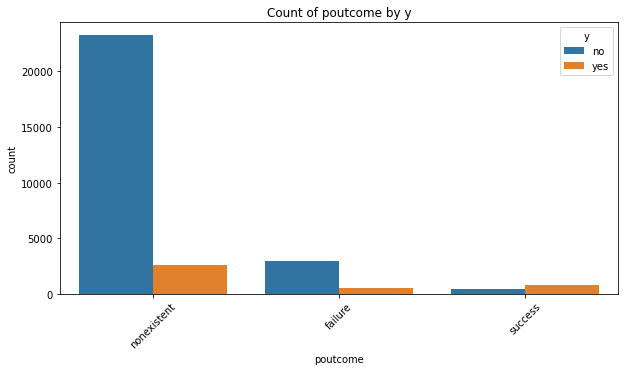

In [21]:
for column in bank_clean_data.columns:
    if bank_clean_data[column].dtype == 'object' and column != 'y':
        plt.figure(figsize = (10, 5))
        plt.title(f'Count of {column} by y')
        plt.xticks(rotation = 45)
        sns.countplot(x = column, data = bank_clean_data, hue = 'y')
        plt.show()

From the bar plots above, we can determine a few things regarding the categorical features. 

- _Day of the Week_ and _Default_ features don't influence the response
    - The value 'yes' for _Default_ has very low occurrences in the dataset, so it won't be a helpful feature to include to predict the response
    - All the values for _Day of the Week_ has the same ratio for yes to know, so including the feature in the classifier won't be helpful for the predictions

- For the other categorical features, the ratio of yes to no is different for each categorical feature value, so those features influence the response 
    - These features are _job_, _marital_, _education_, _housing_, _loan_, _contact_, _month_, _poutcome_

##### Create a correlation matrix for the numerical features and the encoded response

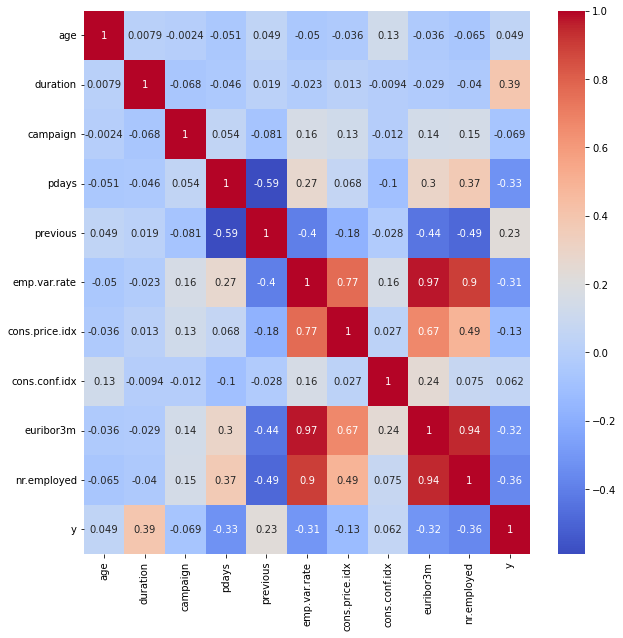

In [22]:
bank_clean_data_num = bank_clean_data.select_dtypes(include = ['int64', 'float64'])
bank_clean_data_num['y'] = bank_clean_data['y'].map({'no': 0, 'yes': 1})

correlation_matrix = bank_clean_data_num.corr()

plt.figure(figsize = (10, 10))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

From the correlation matrix above, we see that some of the numerical values don't strongly influence the response _y_, so those numerical values shouldn't be included in the classifier model. The remaining numerical features that we will keep are _nr.employed_, _euribor3m_, _cons.price.idx_, _emp.var.rate_, _previous_, and _pdays_. 

Although _duration_ also has high correlation to the response _y_, we will not use that feature since it isn't known till after the call is complete, so it isn't useful for our classifier. 

#### Set Features and Outcome

In [23]:
relevant_categorical = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome']

threshold = 0.2
relevant_numerical = correlation_matrix[correlation_matrix['y'].abs() > threshold].index.tolist()
relevant_numerical.remove('duration')
relevant_numerical.remove('y') 

X = bank_clean_data[relevant_categorical + relevant_numerical]
y = bank_clean_data['y']

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30477 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job           30477 non-null  object 
 1   marital       30477 non-null  object 
 2   education     30477 non-null  object 
 3   housing       30477 non-null  object 
 4   loan          30477 non-null  object 
 5   contact       30477 non-null  object 
 6   month         30477 non-null  object 
 7   poutcome      30477 non-null  object 
 8   pdays         30477 non-null  int64  
 9   previous      30477 non-null  int64  
 10  emp.var.rate  30477 non-null  float64
 11  euribor3m     30477 non-null  float64
 12  nr.employed   30477 non-null  float64
dtypes: float64(3), int64(2), object(8)
memory usage: 3.3+ MB
None
<class 'pandas.core.series.Series'>
Int64Index: 30477 entries, 0 to 41187
Series name: y
Non-Null Count  Dtype 
--------------  ----- 
30477 non-null  object
dtypes: object(1)
mem

#### Create Train and Test Sets

In [24]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 143)

#### Calculate CPU Count

In [25]:
n_cpus = multiprocessing.cpu_count()
n_cpus

10

#### Set Number of Jobs for the Grid Search

In [26]:
n_jobs = min(6, n_cpus)

#### Hyperparameter Tuning with Grid Search

Use grid search to tune different hyper parameters. Train using the accuracy metric. To save compute time on SVM, Halving Grid Search will be used instead as it is faster. The rest will use Grid Search.  

In [27]:
# logistic regression

extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear', random_state = 42))

lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

params = {'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100]}

start_time = time.time()

lgr_gs = GridSearchCV(lgr_pipe, param_grid=params, cv=5, scoring='accuracy', n_jobs=n_jobs).fit(X_train, y_train)
lgr_fit_time = time.time() - start_time

lgr_train_score = lgr_gs.best_score_
lgr_test_score = lgr_gs.score(X_test, y_test)

lgr_accuracy = accuracy_score(y_test, lgr_gs.predict(X_test))
lgr_precision = precision_score(y_test, lgr_gs.predict(X_test), pos_label='yes')
lgr_recall = recall_score(y_test, lgr_gs.predict(X_test), pos_label='yes')

print(lgr_gs.best_params_)

print('Train Score:', lgr_train_score)
print('Test Score:', lgr_test_score)

print('Accuracy:', lgr_accuracy)
print('Precision:', lgr_precision)
print('Recall:', lgr_recall)

{'lgr__C': 1}
Train Score: 0.8888068133172012
Test Score: 0.8843503937007874
Accuracy: 0.8843503937007874
Precision: 0.6575342465753424
Recall: 0.24090338770388958


In [28]:
# KNN

knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier())
])

params = {'knn__n_neighbors': [n for n in range(1,22,2)]}

start_time = time.time()

knn_gs = GridSearchCV(knn_pipe, param_grid=params, cv=5, scoring='accuracy', n_jobs=n_jobs).fit(X_train, y_train)
knn_fit_time = time.time() - start_time

knn_train_score = knn_gs.best_score_
knn_test_score = knn_gs.score(X_test, y_test)

knn_accuracy = accuracy_score(y_test, knn_gs.predict(X_test))
knn_precision = precision_score(y_test, knn_gs.predict(X_test), pos_label='yes')
knn_recall = recall_score(y_test, knn_gs.predict(X_test), pos_label='yes')

print(knn_gs.best_params_)

print('Train Score:', knn_train_score)
print('Test Score:', knn_test_score)

print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)

{'knn__n_neighbors': 21}
Train Score: 0.8870841486456914
Test Score: 0.8828740157480315
Accuracy: 0.8828740157480315
Precision: 0.6269113149847095
Recall: 0.2572145545796738


In [29]:
# decision tree

dtree_pipe = Pipeline([
    ('transformer', transformer),
    ('dt', DecisionTreeClassifier(random_state=42))
])

params = {'dt__max_depth': range(1,11,2),
          'dt__min_samples_split': [2,3,4,5],
          'dt__min_samples_leaf': [1,2,3,4,5],
          'dt__criterion': ['gini', 'entropy']}

start_time = time.time()

dtree_gs = GridSearchCV(dtree_pipe, param_grid=params, cv=5, scoring='accuracy', n_jobs=n_jobs).fit(X_train, y_train)
dtree_fit_time = time.time() - start_time

dtree_train_score = dtree_gs.best_score_
dtree_test_score = dtree_gs.score(X_test, y_test)

dtree_accuracy = accuracy_score(y_test, dtree_gs.predict(X_test))
dtree_precision = precision_score(y_test, dtree_gs.predict(X_test), pos_label='yes')
dtree_recall = recall_score(y_test, dtree_gs.predict(X_test), pos_label='yes')

print(dtree_gs.best_params_)

print('Train Score:', dtree_train_score)
print('Test Score:', dtree_test_score)

print('Accuracy:', dtree_accuracy)
print('Precision:', dtree_precision)
print('Recall:', dtree_recall)


{'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2}
Train Score: 0.8895451486384583
Test Score: 0.8891076115485564
Accuracy: 0.8891076115485564
Precision: 0.6753623188405797
Recall: 0.29234629861982436


In [36]:
# SVM

svm_pipe = Pipeline([
    ('transformer', transformer),
    ('svm', SVC())
])

params = {'svm__C': [0.1, 1, 10],
          'svm__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
          'svm__gamma': [0.1, 1.0, 10.0]}

start_time = time.time()

svm_gs = HalvingGridSearchCV(svm_pipe, param_grid=params, cv=5, scoring='accuracy', n_jobs=n_jobs).fit(X_train, y_train)
svm_fit_time = time.time() - start_time

svm_train_score = svm_gs.best_score_
svm_test_score = svm_gs.score(X_test, y_test)

svm_accuracy = accuracy_score(y_test, svm_gs.predict(X_test))
svm_precision = precision_score(y_test, svm_gs.predict(X_test), pos_label='yes')
svm_recall = recall_score(y_test, svm_gs.predict(X_test), pos_label='yes')

print(svm_gs.best_params_)

print('Train Score:', svm_train_score)
print('Test Score:', svm_test_score)

print('Accuracy:', svm_accuracy)
print('Precision:', svm_precision)
print('Recall:', svm_recall)

{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Train Score: 0.8881915633190094
Test Score: 0.886975065616798
Accuracy: 0.886975065616798
Precision: 0.6901408450704225
Recall: 0.24592220828105396


##### Model performance when training the accuracy metric and using grid search strategies

In [37]:
findings_dict = {'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC'], 
                'train score': [lgr_train_score, knn_train_score, dtree_train_score, svm_train_score],
                'test score': [lgr_test_score, knn_test_score, dtree_test_score, svm_test_score],
                'accuracy': [lgr_accuracy, knn_accuracy, dtree_accuracy, svm_accuracy],
                'precision': [lgr_precision, knn_precision, dtree_precision, svm_precision],
                'recall': [lgr_recall, knn_recall, dtree_recall, svm_recall],
                'fit time': [lgr_fit_time, knn_fit_time, dtree_fit_time, svm_fit_time]}

findings_df = pd.DataFrame(findings_dict)
findings_df

,model,train score,test score,accuracy,precision,recall,fit time
0,Logistic Regression,0.888807,0.884350,0.884350,0.657534,0.240903,5.490487
1,KNN,0.887084,0.882874,0.882874,0.626911,0.257215,62.493935
2,Decision Tree,0.889545,0.889108,0.889108,0.675362,0.292346,20.837059
3,SVC,0.888192,0.886975,0.886975,0.690141,0.245922,52.332060


#### Adjust Performance Metric

Precision is also very important for this problem. The bank wants to target customers in its marketing campaign who are likely to subscribe in order to be cost effective. We will tune the models for the precision metric as well. To save compute time on SVM, Halving Grid Search will be used instead as it is faster. The rest will use Grid Search.  

In [38]:
precision_scorer = make_scorer(precision_score, pos_label='yes')

In [39]:
# logistic regression

extractor = SelectFromModel(LogisticRegression(penalty='l1', solver = 'liblinear', random_state = 42))

lgr_pipe = Pipeline([('transformer', transformer),
                    ('selector', extractor),
                    ('lgr', LogisticRegression(random_state=42, max_iter = 1000))])

params = {'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100]}

start_time = time.time()

lgr_gs = GridSearchCV(lgr_pipe, param_grid=params, cv=5, scoring=precision_scorer, n_jobs=n_jobs).fit(X_train, y_train)
lgr_fit_time = time.time() - start_time

lgr_train_score = lgr_gs.best_score_
lgr_test_score = lgr_gs.score(X_test, y_test)

lgr_accuracy = accuracy_score(y_test, lgr_gs.predict(X_test))
lgr_precision = precision_score(y_test, lgr_gs.predict(X_test), pos_label='yes')
lgr_recall = recall_score(y_test, lgr_gs.predict(X_test), pos_label='yes')

print(lgr_gs.best_params_)

print('Train Score:', lgr_train_score)
print('Test Score:', lgr_test_score)

print('Accuracy:', lgr_accuracy)
print('Precision:', lgr_precision)
print('Recall:', lgr_recall)

{'lgr__C': 0.001}
Train Score: 0.7023762902584165
Test Score: 0.680327868852459
Accuracy: 0.8836942257217848
Precision: 0.680327868852459
Recall: 0.20828105395232122


In [40]:
# KNN

knn_pipe = Pipeline([
    ('transform', transformer),
    ('knn', KNeighborsClassifier())
])

params = {'knn__n_neighbors': [n for n in range(1,22,2)]}

start_time = time.time()

knn_gs = GridSearchCV(knn_pipe, param_grid=params, cv=5, scoring=precision_scorer, n_jobs=n_jobs).fit(X_train, y_train)
knn_fit_time = time.time() - start_time

knn_train_score = knn_gs.best_score_
knn_test_score = knn_gs.score(X_test, y_test)

knn_accuracy = accuracy_score(y_test, knn_gs.predict(X_test))
knn_precision = precision_score(y_test, knn_gs.predict(X_test), pos_label='yes')
knn_recall = recall_score(y_test, knn_gs.predict(X_test), pos_label='yes')

print(knn_gs.best_params_)

print('Train Score:', knn_train_score)
print('Test Score:', knn_test_score)

print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)

{'knn__n_neighbors': 21}
Train Score: 0.6286992679374481
Test Score: 0.6269113149847095
Accuracy: 0.8828740157480315
Precision: 0.6269113149847095
Recall: 0.2572145545796738


In [41]:
# decision tree

dtree_pipe = Pipeline([
    ('transformer', transformer),
    ('dt', DecisionTreeClassifier(random_state=42))
])

params = {'dt__max_depth': range(1,11,2),
          'dt__min_samples_split': [2,3,4,5],
          'dt__min_samples_leaf': [1,2,3,4,5],
          'dt__criterion': ['gini', 'entropy']}

start_time = time.time()

dtree_gs = GridSearchCV(dtree_pipe, param_grid=params, cv=5, scoring=precision_scorer, n_jobs=n_jobs).fit(X_train, y_train)
dtree_fit_time = time.time() - start_time

dtree_train_score = dtree_gs.best_score_
dtree_test_score = dtree_gs.score(X_test, y_test)

dtree_accuracy = accuracy_score(y_test, dtree_gs.predict(X_test))
dtree_precision = precision_score(y_test, dtree_gs.predict(X_test), pos_label='yes')
dtree_recall = recall_score(y_test, dtree_gs.predict(X_test), pos_label='yes')

print(dtree_gs.best_params_)

print('Train Score:', dtree_train_score)
print('Test Score:', dtree_test_score)

print('Accuracy:', dtree_accuracy)
print('Precision:', dtree_precision)
print('Recall:', dtree_recall)

/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification

{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Train Score: 0.6972193239210129
Test Score: 0.701195219123506
Accuracy: 0.8858267716535433
Precision: 0.701195219123506
Recall: 0.22082810539523212


In [43]:
#SVM

svm_pipe = Pipeline([
    ('transformer', transformer),
    ('svm', SVC())
])

params = {'svm__C': [0.1, 1, 10],
          'svm__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
          'svm__gamma': [0.1, 1.0, 10.0]}

start_time = time.time()

svm_gs = HalvingGridSearchCV(svm_pipe, param_grid=params, cv=5, scoring=precision_scorer, n_jobs=n_jobs).fit(X_train, y_train)
svm_fit_time = time.time() - start_time

svm_train_score = svm_gs.best_score_
svm_test_score = svm_gs.score(X_test, y_test)

svm_accuracy = accuracy_score(y_test, svm_gs.predict(X_test))
svm_precision = precision_score(y_test, svm_gs.predict(X_test), pos_label='yes')
svm_recall = recall_score(y_test, svm_gs.predict(X_test), pos_label='yes')

print(svm_gs.best_params_)

print('Train Score:', svm_train_score)
print('Test Score:', svm_test_score)

print('Accuracy:', svm_accuracy)
print('Precision:', svm_precision)
print('Recall:', svm_recall)

/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/cert/lib/python3.10/site-packages/sklearn/metrics/_classification

{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Train Score: 0.6781628599379534
Test Score: 0.6901408450704225
Accuracy: 0.886975065616798
Precision: 0.6901408450704225
Recall: 0.24592220828105396


##### Model performance when training the accuracy metric and using grid search strategies

In [44]:
findings_dict = {'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVC'], 
                'train score': [lgr_train_score, knn_train_score, dtree_train_score, svm_train_score],
                'test score': [lgr_test_score, knn_test_score, dtree_test_score, svm_test_score],
                'accuracy': [lgr_accuracy, knn_accuracy, dtree_accuracy, svm_accuracy],
                'precision': [lgr_precision, knn_precision, dtree_precision, svm_precision],
                'recall': [lgr_recall, knn_recall, dtree_recall, svm_recall],
                'fit time': [lgr_fit_time, knn_fit_time, dtree_fit_time, svm_fit_time]}

findings_df = pd.DataFrame(findings_dict)
findings_df

,model,train score,test score,accuracy,precision,recall,fit time
0,Logistic Regression,0.702376,0.680328,0.883694,0.680328,0.208281,5.070589
1,KNN,0.628699,0.626911,0.882874,0.626911,0.257215,50.275475
2,Decision Tree,0.697219,0.701195,0.885827,0.701195,0.220828,26.226553
3,SVC,0.678163,0.690141,0.886975,0.690141,0.245922,61.642234


### Problem 12: Conclusion

#### Best Classifier

The best classifier is one that has both high accuracy and high precision while being trained quickly. Decision Tree that uses Grid Search and is trained on the Precision Metric is the best classifier. It has an accuracy of 89% and precision of 70%. It took 26 seconds to train the classifier model using Grid Search. 

The best parameters for the Decision Tree classifier are `{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}`. 

#### Important Features

In [57]:
feature_names = dtree_gs.best_estimator_['transformer'].get_feature_names_out()

importances = [(feature_names[i], dtree_gs.best_estimator_['dt'].feature_importances_[i]) for i in range(len(feature_names)) if dtree_gs.best_estimator_['dt'].feature_importances_[i] != 0]

print(importances)

[('onehotencoder__contact_telephone', 0.021543338441457754), ('onehotencoder__month_oct', 0.023761659490293484), ('remainder__pdays', 0.13945414730513178), ('remainder__euribor3m', 0.10036344072019321), ('remainder__nr.employed', 0.7148774140429237)]


The most important features that are used to predict a customer's repsonse are __contact__, __month__, __pdays__, __euribor3m__, and __nr.employed__. If the contact method was a telephone or the month was October when the call was made, customers were likely to subscribe to the deposit during a marketing campaign. Additionally, low number of days since the customer was previously contacted, low euribor 3 month rate, and low number of employees greatly influence a customer's response to subscribe. 

#### Final Recommendations

Based on these factors, Decision Tree classifier trained using Grid Search on the Precision Metric is the best classifier that the bank should implement to determine if the client subscribes to the deposit offered during the campaign. 

The parameters for the Decision Tree classifier that the bank should use are `{'dt__criterion': 'gini', 'dt__max_depth': 3, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}`. 

Using this classifier, the bank will enhance campaign efficiency. 

The bank should specifically target customers they have contacted recently in the month of October with a telephone. They should contact customers when there are low number of employees or a low euribor 3 month rate. This understanding about which types of customers to contact, along with when and how to contact them, will lead to imoroved resource management, including optimizing human effort, phone calls, and time allocation.